# cnn text classification

In [85]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.4.1


In [91]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
# model_dir = tempfile.mkdtemp()
model_dir = './checkpoint/cnn_classifier'

# we assign the first indices in the vocabulary to special tokens that we use
# for padding, as start token, and for indicating unknown words
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size, start_char=start_id, oov_char=oov_id,
    index_from=index_offset)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [88]:
word_index = imdb.get_word_index()
word_inverted_index = {v + index_offset: k for k, v in word_index.items()}

# The first indexes in the map are reserved to represent things other than tokens
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'

for i in range(0, 10):
    print(i, word_inverted_index[i])
  
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

0 <PAD>
1 <START>
2 <OOV>
3 the
4 and
5 a
6 of
7 to
8 is
9 br
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly <OOV> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big <OOV> for the whole film bu

In [89]:
#input function

x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

#len을 활용하여 기존 전처리 이후의 길이를 보존
#from_tensor_slices를 활용하면 numpy 데이터 구조에서 쉽게 변환

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

# CNN Classification

CNN을 활용하여 text를 분류해보자, n-gram의 효과로 활용

https://www.semanticscholar.org/paper/Learning-to-Rank-Short-Text-Pairs-with-Deep-Neural-Severyn-Moschitti/452f7411af7d471dd3ba84c2b06b2aaffc38cdb9

Embedding Layer -> Dropout -> Conv1D -> GlobalMax1D -> Hidden Dense Layer -> Dropout -> Output Layer

In [95]:
all_classifiers = {}

def train_and_evaluate(classifier):
    # 예측 테스트를 위해 모델을 학습시키고 저장한다.
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
    
    # name scopes의 재사용을 위해 graph를 reset한다.
    tf.reset_default_graph()
    
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool),
                             num_thresholds=21)
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()

In [96]:
#head: pre-made estimator로 평가를 할 때, 일정한 함수를 사용하게 세팅
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):
    #embedding layer를 선언한다.
    input_layer = tf.contrib.layers.embed_sequence(
                    features['x'],
                    vocab_size,
                    embedding_size,
                    initializer=params['embedding_initializer']
                    )

    training = (mode == tf.estimator.ModeKeys.TRAIN)
    dropout_emb = tf.layers.dropout(inputs=input_layer,
                                   rate=0.2,
                                   training=training)

    conv = tf.layers.conv1d(
            inputs=dropout_emb,
            filters=32,
            kernel_size=3,
            padding='same',
            activation=tf.nn.relu)
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)  
    dropout_hidden = tf.layers.dropout(inputs=hidden, rate=0.2, training=training)
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    #prediction 진행 시, None
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
    
    optimizer = tf.train.AdamOptimizer() #여러가지 Optimizer 활용가능
    
    def _train_op_fn(loss):
#         tf.summary('loss', loss)
        return optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())

    
    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)

params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoint/cnn_classifier/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1214e2ba8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [97]:
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./checkpoint/cnn_classifier/cnn/model.ckpt.
INFO:tensorflow:loss = 90.836975, step = 1
INFO:tensorflow:global_step/sec: 12.7869
INFO:tensorflow:loss = 69.78476, step = 101 (7.822 sec)
INFO:tensorflow:global_step/sec: 13.386
INFO:tensorflow:loss = 66.52496, step = 201 (7.470 sec)
INFO:tensorflow:global_step/sec: 13.2463
INFO:tensorflow:loss = 56.74327, step = 301 (7.549 sec)
INFO:tensorflow:global_step/sec: 12.8295
INFO:tensorflow:loss = 60.572372, step = 401 (7.795 sec)
INFO:tensorflow:global_step/sec: 12.884
INFO:tensorflow:loss = 47.06904, step = 501 (7.761 sec)
INFO:tensorflow:global_step/sec: 11.7084
INFO:tensorflow:loss = 43.126133, step = 601 (8.541 sec)
INFO:tensorflow:global_step/sec: 12.808
INFO:tensorflow:loss = 57.06847, step = 701 (7.807 sec)
INFO:tensorflow:global_step/sec: 13.134
INFO:tensorflow:loss = 42.21399, step = 801 (7.614 sec)
INFO:tensorflow:global_step/sec: 12.6357
INFO:ten

KeyboardInterrupt: 

In [104]:
def text_to_index(sentence):
    # Remove punctuation characters except for the apostrophe
    translator = str.maketrans('', '', string.punctuation.replace("'", ''))
    tokens = sentence.translate(translator).lower().split()
    return np.array([1] + [word_index[t] if t in word_index else oov_id for t in tokens])

def print_predictions(sentences):
    indexes = [text_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               truncating='post',
                               padding='post',
                               value=pad_id)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers:
            print("\t{} {}".format(path, predictions[path][idx]))
            
print_predictions([
    'I really liked the movie!',
    'Hated every second of it...'])

INFO:tensorflow:Restoring parameters from ./checkpoint/cnn_classifier/cnn/model.ckpt-1
I really liked the movie!
	./checkpoint/cnn_classifier/cnn 0.4765971899032593
Hated every second of it...
	./checkpoint/cnn_classifier/cnn 0.530629575252533


In [108]:
print_predictions(['I like this movie'])

INFO:tensorflow:Restoring parameters from ./checkpoint/cnn_classifier/cnn/model.ckpt-1
I like this movie
	./checkpoint/cnn_classifier/cnn 0.4677623212337494


# 추가내용

# 간단한 linear model을 활용하여 분류 (Bag-of-Words)

In [5]:
#위의 데이터셋을 가지고 간단한 모델 구현해보기

#categorical_columns_with_identity: pre-processed text 입력에 어울림
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(
            feature_columns=[column],
            model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/6x/lq2g1bqs673f7knw38tdmphm0000gn/T/tmp9vo4rmrt/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x119e291d0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
all_classifiers = {}

def train_and_evaluate(classifier):
    # 예측 테스트를 위해 모델을 학습시키고 저장한다.
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
    
    # name scopes의 재사용을 위해 graph를 reset한다.
    tf.reset_default_graph()
    
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool),
                             num_thresholds=21)
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()
        
# Un-comment code to download experiment data from Colaboratory
#     from google.colab import files
#     model_name = os.path.basename(os.path.normpath(classifier.model_dir))
#     ! zip -r {model_name + '.zip'} {classifier.model_dir}
#     files.download(model_name + '.zip')  

In [ ]:
train_and_evaluate(classifier)

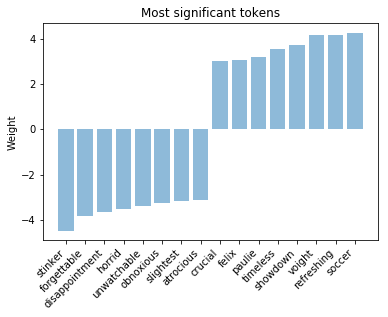

In [8]:
#simple 모델은 내부를 들여보기 쉬운 장점이 있음
#최신의 checkpoint를 활용하여 가장 큰 weights를 가진 요소를 확인
#positive와 negative 값 확인해보면 단어들이 대체적으로 긍정 및 부정

weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

# Embedding

 - dense low-dimensional representation of sparse


In [ ]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))
train_and_evaluate(classifier)

In [17]:
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    f.write('label\n')
    for index in range(0, vocab_size):
        f.write(word_inverted_index[index] + '\n')